In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import os.path as osp
import numpy as np

In [3]:
def plot_data(data, xaxis='Epoch', value="AverageEpRet", condition="Condition1", smooth=1, **kwargs):
    if smooth > 1:
        """
        smooth data with moving window average.
        that is,
            smoothed_y[t] = average(y[t-k], y[t-k+1], ..., y[t+k-1], y[t+k])
        where the "smooth" param is width of that window (2k+1)
        """
        y = np.ones(smooth)
        for datum in data:
            x = np.asarray(datum[value])
            z = np.ones(len(x))
            smoothed_x = np.convolve(x,y,'same') / np.convolve(z,y,'same')
            datum[value] = smoothed_x

    if isinstance(data, list):
        data = pd.concat(data, ignore_index=True)
    sns.set(style="darkgrid", font_scale=1.5)
    # sns.tsplot(data=data, time=xaxis, value=value, unit="Unit", condition=condition, ci='sd', **kwargs)
    sns.lineplot(data=data, x=xaxis, y=value, hue=condition, ci='sd', **kwargs)
    """
    If you upgrade to any version of Seaborn greater than 0.8.1, switch from 
    tsplot to lineplot replacing L29 with:

        sns.lineplot(data=data, x=xaxis, y=value, hue=condition, ci='sd', **kwargs)

    Changes the colorscheme and the default legend style, though.
    """
    plt.legend(loc='best').set_draggable(True)
    #plt.legend(loc='upper center', ncol=3, handlelength=1,
    #           borderaxespad=0., prop={'size': 13})

    """
    For the version of the legend used in the Spinning Up benchmarking page, 
    swap L38 with:

    plt.legend(loc='upper center', ncol=6, handlelength=1,
               mode="expand", borderaxespad=0., prop={'size': 13})
    """

    xscale = np.max(np.asarray(data[xaxis])) > 5e3
    if xscale:
        # Just some formatting niceness: x-axis scale in scientific notation if max x is large
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    plt.tight_layout(pad=0.5)

In [4]:
   
def generate_eval_plots(eval_save_dir, eval_files_dict):
    model_dataframes = []
    for model_name, seed_files in eval_files_dict.items():
        seed_dataframes = []
        for seed_eval_file in seed_files: 
            with open(os.path.join(eval_save_dir, seed_eval_file), 'r') as json_file:
                data = json.load(json_file)
                data = pd.DataFrame(data)
                seed_dataframes.append(data)
        seed_eval_df = pd.concat(seed_dataframes)
        seed_eval_df['model'] = model_name
        model_dataframes.append(seed_eval_df)
    model_dfs = pd.concat(model_dataframes)

    sns.violinplot(data=model_dfs, x='model', y='returns')

    plt.figure()
    sns.violinplot(data=model_dfs, x='model', y='avg_connectivity')

    ################ REPORT RESULTS #####################
    return_results = model_dfs.groupby('model')["returns"].agg(["mean", "std"])
    connectivity_results = model_dfs.groupby('model')["avg_connectivity"].agg(["mean", "std"])
    print(return_results)
    print(connectivity_results)


                                mean        std
model                                          
SC-GNN (3-robots, seen)   -21.532280   9.740979
SC-GNN (3-robots, unseen) -21.964584  10.052821
                               mean       std
model                                        
SC-GNN (3-robots, seen)    2.574893  0.419237
SC-GNN (3-robots, unseen)  2.591605  0.415382


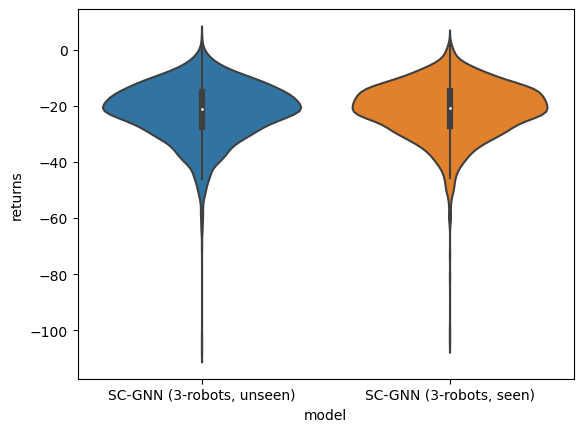

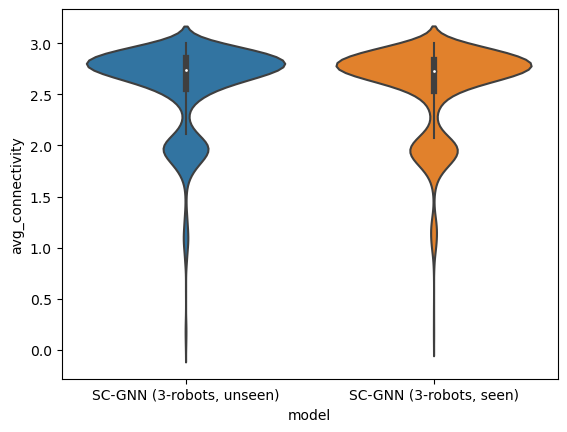

In [7]:
################# REPORT RESULTS FOR EVALUATION
eval_save_dir = "/home/dwalkerhowell3/star_lab/ca-gnn-marl/Heterogeneous-MARL-CA/robotarium_gym/scenarios/HeterogeneousSensorNetwork/eval_saves"

# we want to aggregate same models with different seeds
eval_files_dict = {"SC-GNN (3-robots, unseen)":
                ["SC_3_agents_HSN_seed_1_test_3_agents.json",
                 "SC_3_agents_HSN_seed_2_test_3_agents.json",
                 "SC_3_agents_HSN_seed_3_test_3_agents.json"],

              "SC-GNN (3-robots, seen)":
                ["SC_3_agents_HSN_seed_1_test_3_agents_trained_coalitions.json",
                 "SC_3_agents_HSN_seed_2_test_3_agents_trained_coalitions.json",
                 "SC_3_agents_HSN_seed_3_test_3_agents_trained_coalitions.json"]}

generate_eval_plots(eval_save_dir, eval_files_dict)